<div style="color:#00BFFF">

# Nowcasting Consumer Expenditure: 

### Further Analysis for fitting data to model


To enhance our predictive models, we employ Principal Component Regression (PCR) analysis. This methodology combines Principal Component Analysis (PCA) with Linear Regression, addressing issues of multicollinearity among predictors while leveraging dimensionality reduction to improve model performance.

Through the application of PCR analysis, this project aims to offer timely insights into consumer spending, addressing the existing gaps in economic data reporting. The predictive model and its visual representation through the fan chart illustrate our methodology's potential to inform more responsive economic decision-making.

<div style="color:#00BFFF">

##### Setup Environment and import libraries

In [1]:
# ------- Standard Library Imports -------

from datetime import datetime

# ------- Third-Party Library Imports -------
import pandas as pd
from pandas import NaT
import numpy as np
import missingno as msno

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Set the display options
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  

/var/folders/30/bhymp02j1fb47cmvs80_1b4m0000gn/T/ipykernel_34663/3857042491.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<div style="color:#00BFFF">

##### Load Data

In [2]:
#load data generated from [2]M1_Exploratory_Data_analytics.ipynb

#open final_proxy_dataset.csv
final_proxy_dataset = pd.read_csv('./results/final_dataset/final_proxy_dataset.csv', index_col=0,parse_dates=False)

In [3]:
refined_datset = final_proxy_dataset.copy()
refined_datset.tail(2)

,All Employees: Service-Providing Industries,All Employees: Total nonfarm,Civilian Employment,Civilian Unemployment Rate,M1 Money Stock,All Employees: Retail Trade,"All Employees: Trade, Transportation & Utilities",PCE
202306,0.388879,0.387101,0.111861,0.1,0.0,-0.024473,-0.058908,0.814426
202309,0.446608,0.423896,0.338548,0.2,0.0,0.054090,0.079691,1.404393


<div style="color:#00BFFF">

##### Implementation of Principal Component Regression (PCR) Analysis


<div style="color:#00BFFF">

##### Data Preparation

In [4]:
# Check for missing values in the new dataset
missing_values_summary = final_proxy_dataset.isnull().sum()

# Display the number of missing values for each column if any
missing_values_summary[missing_values_summary > 0]


Series([], dtype: int64)

In [5]:
#if missing values:

#ffill and bfill missing values
final_proxy_dataset.fillna(method='ffill', inplace=True)
final_proxy_dataset.fillna(method='bfill', inplace=True)

# # Visualize missing values
# msno.matrix(refined_datset)

In [6]:
# 'final_proxy_dataset' index is in 'YYYYMM' string format
final_proxy_dataset.index = pd.to_datetime(final_proxy_dataset.index, format='%Y%m')

final_proxy_dataset.tail()

,All Employees: Service-Providing Industries,All Employees: Total nonfarm,Civilian Employment,Civilian Unemployment Rate,M1 Money Stock,All Employees: Retail Trade,"All Employees: Trade, Transportation & Utilities",PCE
2022-09-01,0.848286,0.829815,0.490837,-0.1,0.0,0.226028,0.393352,1.533394
2022-12-01,0.541766,0.553508,0.255190,0.0,0.0,-0.158166,-0.059078,1.307840
2023-03-01,0.671799,0.604504,0.952138,0.0,0.0,0.331538,0.347018,1.948849
2023-06-01,0.388879,0.387101,0.111861,0.1,0.0,-0.024473,-0.058908,0.814426
2023-09-01,0.446608,0.423896,0.338548,0.2,0.0,0.054090,0.079691,1.404393



The first step involves preparing the dataset for analysis. We split the data based on a specified cutoff date, separating it into training and testing sets. This separation allows us to simulate a realistic forecasting scenario, where the model is trained on historical data and tested on unseen, future data.

```python
X_train, y_train, X_test, C, df_train, df_test = prepare_data(final_proxy_dataset, '2010-12')
```

In [7]:
def prepare_data(final_proxy_dataset, cutoff_date='2022-12', format='%Y-%m'):
    """
    Prepares the dataset for training and testing.
    """
    # Convert string dates to datetime format for comparison
    cutoff_date_dt = pd.to_datetime(cutoff_date, format=format)
    
    # Splitting the dataset based on the cutoff date
    df_train = final_proxy_dataset[final_proxy_dataset.index < cutoff_date_dt]
    df_test = final_proxy_dataset[final_proxy_dataset.index >= cutoff_date_dt]
    
    # Separate predictors and target
    X_train = df_train.drop(columns=['PCE'])
    y_train = df_train['PCE']
    X_test = df_test.drop(columns=['PCE'])
    C = df_test['PCE']
    
    return X_train, y_train, X_test, C, df_train, df_test



<div style="color:#00BFFF">

##### Model Training and Prediction



We then proceed to train our PCR model. The process integrates data standardization, PCA for dimensionality reduction, and linear regression for prediction. This pipeline ensures that the model captures the essential dynamics of the data while mitigating the risk of overfitting.

```python
pipeline, predicted_pce = train_and_predict(X_train, y_train, X_test, n_components=5)
```

In [8]:
from sklearn.pipeline import Pipeline


def train_and_predict(X_train, y_train, X_test, n_components=5):
    """
    Trains the model and makes predictions, and returns the fitted PCA component.

    Parameters:
    - X_train: Training data features
    - y_train: Training data target variable
    - X_test: Test data features
    - n_components: Number of PCA components

    Returns:
    - pipeline: The fitted pipeline
    - predicted_pce: Predictions for the test set
    - pca_component: The PCA component of the pipeline
    """
    # Creating pipeline
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=n_components)),
            ("regressor", LinearRegression()),
        ]
    )

    # Fitting the model to the training data
    pipeline.fit(X_train, y_train)

    # Making predictions
    predicted_pce = pipeline.predict(X_test)

    # Extracting the PCA component from the pipeline
    pca_component = pipeline.named_steps["pca"]

    return pipeline, predicted_pce, pca_component


<div style="color:#00BFFF">

##### Visualization with a Fan Chart


Finally, we visualize the actual versus predicted Personal Consumption Expenditures (PCE) using a fan chart. This chart starts from a specified date, showcasing the model's predictions and associated uncertainties. The visualization underscores the model's performance and highlights the predictive uncertainty, providing a comprehensive view of the forecast's reliability.

```python
plot_fan_chart(df_train, C, predicted_pce, X_train, y_train, start_date='2007-03-01')
```

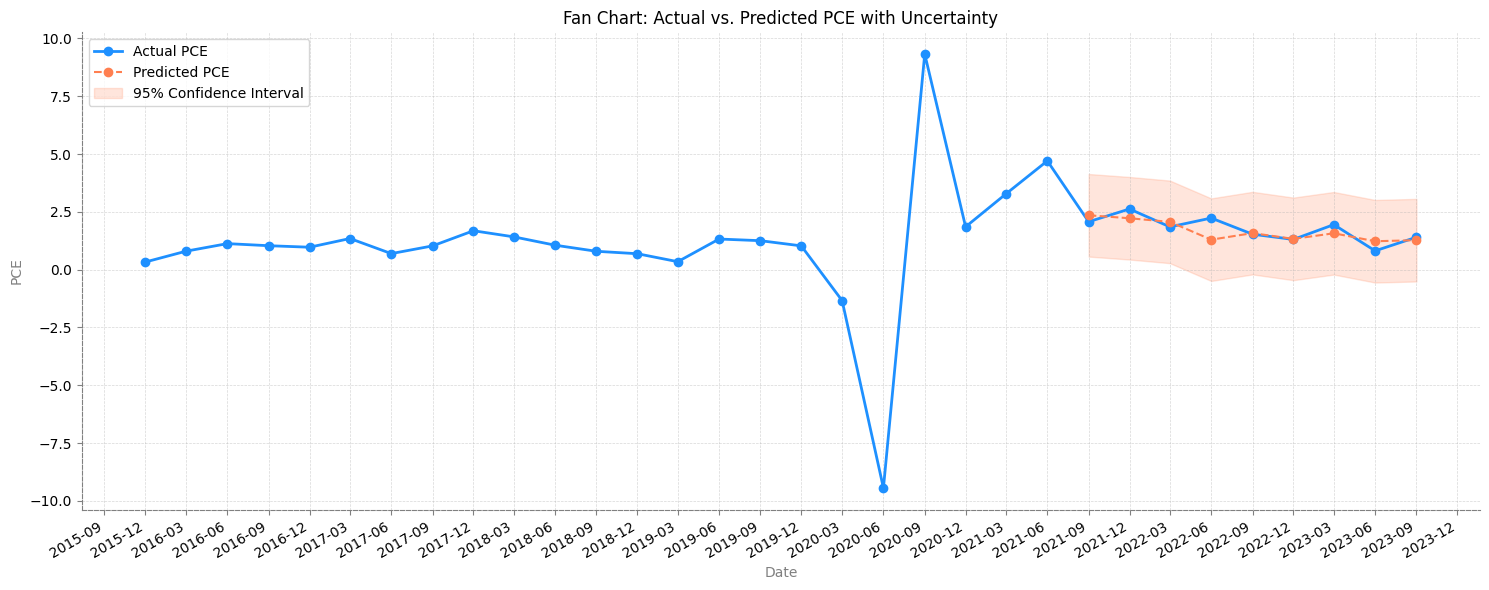

In [9]:
from visualisations.plot_fan_chart import plot_fan_chart

prediction_start_date = '2021-09'
actual_values_start_date = '2015-09-30'
n_components = 2

# Prepare the data
X_train, y_train, X_test, C, df_train, df_test = prepare_data(final_proxy_dataset, prediction_start_date)

# Train the model and make predictions
pipeline, predicted_pce, pca_component = train_and_predict(X_train, y_train, X_test,n_components=n_components)

# Plot the fan chart
plot_fan_chart(df_train, C, predicted_pce, X_train, y_train, start_date=actual_values_start_date)



<div style="color:#00BFFF">

##### PCA Analysis : Interpretation of Results

Our Principal Component Regression (PCR) analysis focused on predicting Personal Consumption Expenditures (PCE), aiming to provide insights into consumer spending behavior, especially during the rapidly changing economic landscape influenced by the COVID-19 pandemic. The primary goal was to leverage high-frequency data proxies to forecast PCE more timely than traditional economic reports.

<div style="color:#00BFFF">

##### Predicted PCE


</div>

The PCR model generated predictions for future PCE values as follows:

These predictions fall within a range that reflects normal consumer spending behavior, especially when compared to the extreme values observed during COVID-19, where the scale reached between -10 and 10. For the majority of the timeline, the model's predictions suggest a stabilized consumer spending pattern, with values ranging between 1 and 5.


In [10]:
from IPython.display import display, Markdown
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.markdown_generator import (
    generate_cv_performance_markdown,
    generate_model_performance_markdown,
)


def perform_time_series_cv(X, y, n_components=5, n_splits=5):
    """
    Performs time series cross-validation and returns MSE scores.
    """
    # Initialize the TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=n_splits)

    mse_scores = []

    for train_index, test_index in tscv.split(X):
        # Use different variable names for the train/test splits to avoid modifying the original datasets
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Create and fit the pipeline
        pipeline = make_pipeline(
            StandardScaler(), PCA(n_components=n_components), LinearRegression()
        )
        pipeline.fit(X_train_fold, y_train_fold)

        # Make predictions and calculate MSE
        predictions = pipeline.predict(X_test_fold)
        mse = mean_squared_error(y_test_fold, predictions)
        mse_scores.append(mse)

    return mse_scores

In [11]:

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(C, predicted_pce)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(C, predicted_pce, squared=False)  # Set squared=False for RMSE

# Perform time series cross-validation
mse_scores = perform_time_series_cv(X_train, y_train, n_components=n_components, n_splits=5)

# Generate the Markdown content
markdown_content = generate_model_performance_markdown(mae, rmse, predicted_pce)
markdown_output = generate_cv_performance_markdown(mse_scores)

# Display the Markdown content
display(Markdown(markdown_content))
display(Markdown(markdown_output))


<div style="color:#FF7F50">

##### Model Performance

</div>

The predicted PCE values for the model is 2.3523, 2.2245, 2.0670, 1.2980, 1.5807, 1.3320, 1.5740, 1.2295, 1.2759.

The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) provide insights into the model's accuracy:

- **Mean Absolute Error (MAE): 0.3132** suggests that, on average, the model's predictions are approximately 0.3132 units away from the actual PCE values. 
- **Root Mean Squared Error (RMSE): 0.4069** also reflects the model's prediction accuracy, accounting for the square root of the average squared differences between predicted and actual values. 



<div style="color:#FF7F50">

##### Cross-Validation Performance

</div>

The cross-validation process provides an estimate of the model's prediction error across different temporal splits of the dataset. Here are the insights from the time series cross-validation:

- **Mean Squared Error (MSE) Scores for Each Fold:** 0.3732, 0.3166, 0.1402, 0.7774, 0.8435
- **Average Mean Squared Error (Average MSE): 0.4902** suggests that, on average, the squared difference between the model's predictions and the actual PCE values is approximately 0.4902. This metric helps in understanding the average prediction error across all folds, providing insight into the model's overall performance.


<div style="color:#FF7F50">

##### Additional Analysis

</div>


- Understanding the model's performance in the context of economic forecasting is crucial. A lower Average MSE means the model is potentially more reliable for predicting future PCE values, which can aid policymakers and economists in making informed decisions.
- It's important to identify which factors contribute most significantly to prediction errors. Analyzing feature importance and error patterns could reveal insights into economic trends or anomalies.
- Continuous improvement should involve refining the model by exploring additional features, incorporating external economic indicators, or testing more sophisticated forecasting techniques.



<div style="color:#00BFFF">

##### Principal Component Analysis (PCA) factor loadings

</div>

The PCA performed as part of the PCR process aimed to address multicollinearity among predictors and reduce dimensionality to enhance model performance. The factor loadings heatmap and the scree plot provide insights into the PCA results:

- **Factor Loadings Heatmap**: The heatmap visualization of the first three principal components' factor loadings on various indicators reveals which variables most influence each principal component. This insight helps understand the underlying dimensions of consumer spending behavior captured by the model.

- **Scree Plot**: The scree plot, showing the variance explained by each principal component, illustrates that a significant portion of the variance in the data can be captured by the first few components. This reduction not only simplifies the model but also focuses on the most influential factors driving PCE.


In [12]:
# Extracting factor loadings (the PCA components)
factor_loadings = pca_component.components_

# Mapping factor loadings to original variable names
factor_loadings_df = pd.DataFrame(factor_loadings, columns=X_train.columns, index=[f'PC{i+1}' for i in range(factor_loadings.shape[0])])

# Displaying factor loadings for the first few principal components for brevity
factor_loadings_df.head()

,All Employees: Service-Providing Industries,All Employees: Total nonfarm,Civilian Employment,Civilian Unemployment Rate,M1 Money Stock,All Employees: Retail Trade,"All Employees: Trade, Transportation & Utilities"
PC1,-0.392924,-0.394248,-0.380132,0.385937,0.329816,-0.375464,-0.383380
PC2,-0.013676,-0.134649,0.013971,-0.140116,-0.834566,-0.344725,-0.382778


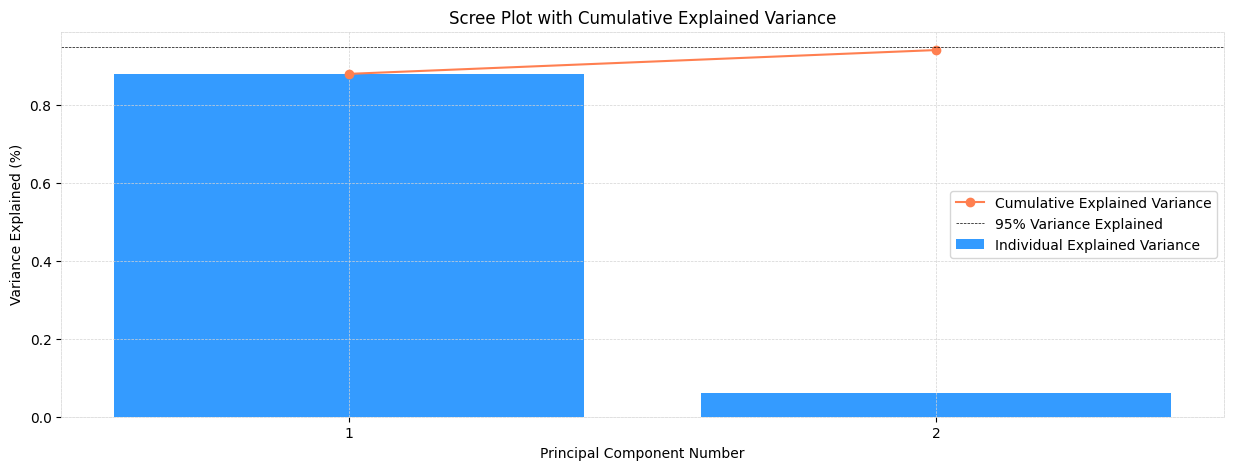

In [13]:
from visualisations.plot_skree import plot_skree

plot_skree(pca_component)

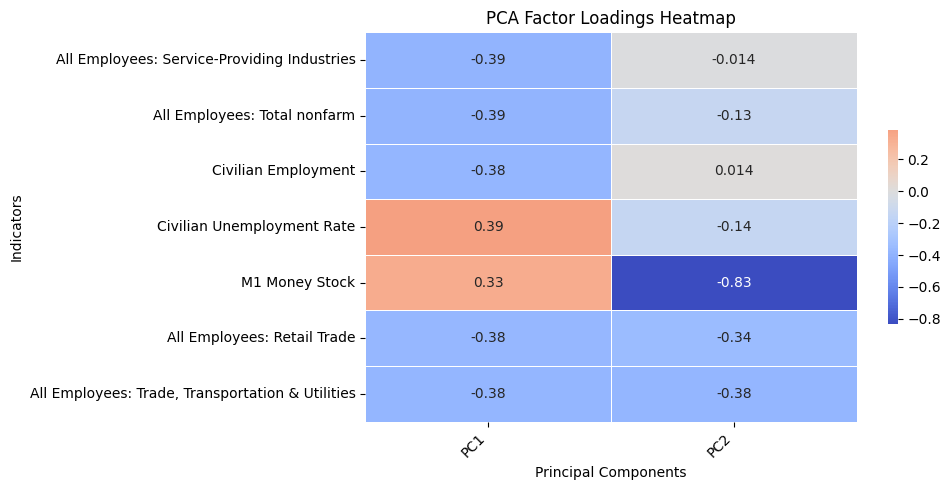

In [14]:
# Plotting the heatmap of the first few factor loadings

plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(factor_loadings_df.iloc[:5, :].transpose(), annot=True, cmap='coolwarm', center=0,
                      linewidths=.5, cbar_kws={"shrink": .5})
heatmap.set_title('PCA Factor Loadings Heatmap')
heatmap.set_xlabel('Principal Components')
heatmap.set_ylabel('Indicators')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


##### Conclusion

The use of PCR, complemented by PCA, demonstrates a sophisticated approach to economic forecasting that can adapt to the complexities of modern economic dynamics.

The PCR model's ability to predict PCE accurately, as evidenced by the low MAE and RMSE, coupled with the insights gained from PCA, positions this approach as a potent tool in economic data analysis. By identifying and validating high-frequency data proxies, this project contributes to the ongoing effort to enhance the timeliness and relevance of economic indicators, ultimately supporting more agile and informed economic decision-making processes.